In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler
import seaborn.objects as so

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# for getting the database library (KEGG)
import gseapy as gp

decoupler is a GSEA algorithm package designed for Python which performs gene-set enrichment, pathway enrichment and overrepresentation enrichment analyses among others. This notebook performs pathway enrichment, a form of geneset enrichment analysis (GSEA) which tests all genes in a geneset of interest for the presence of a cerrtain pathway determined by certain genes.

In [3]:
alldata = sc.read_h5ad('Anndata_Objects/umap/alldata.h5ad')
alldata = alldata [:, ~alldata.var_names.duplicated(keep='first')].copy()
alldata.obs_names_make_unique()

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


To perform pathway enrichment with decoupler querying from KEGG we need the Human ortholog genes for the genes in the dataset. 
We work with gene symbols here. First we get the gene symbols for all genes in the dataset (but not as a background dataset as here decoupler automatically determines a background dataset)

In [4]:
# get mouse gene symbols in the dataset along with Ensembl IDs as index
mouse_names= pd.DataFrame(alldata.var['gene_name'])

Then we make the IDs into a column. The issue here is that we need the gene symbols for enrichment with decoupler but we convert the mouse genes to human using gene IDs so we preserve both now.

In [5]:
# make index to column
mouse_names.reset_index(drop=False, inplace=True)
mouse_names

,id,gene_name
0,ENSMUSG00000051951,Xkr4
1,ENSMUSG00000089699,Gm1992
2,ENSMUSG00000102331,Gm19938
3,ENSMUSG00000033845,Mrpl15
4,ENSMUSG00000033813,Tcea1
...,...,...
18074,ENSMUSG00000055301,Adh7
18075,ENSMUSG00000087541,Hopxos
18076,ENSMUSG00000108441,Gm32846
18077,ENSMUSG00000018924,Alox15


Those are the genes from Biomart that we import as a DataFrame.

In [6]:
# file with human and mouse gene IDs for decoupler which will use human gene IDs (Ensembl)
file= pd.read_csv('mart_export_aha.txt', delimiter='\t') 
# make Ensembl ID column name the same as the column name with mouse Ensembl IDs in the Biomart file
mouse_names.rename(columns={'id': 'Gene stable ID'}, inplace=True)
mouse_names

,Gene stable ID,gene_name
0,ENSMUSG00000051951,Xkr4
1,ENSMUSG00000089699,Gm1992
2,ENSMUSG00000102331,Gm19938
3,ENSMUSG00000033845,Mrpl15
4,ENSMUSG00000033813,Tcea1
...,...,...
18074,ENSMUSG00000055301,Adh7
18075,ENSMUSG00000087541,Hopxos
18076,ENSMUSG00000108441,Gm32846
18077,ENSMUSG00000018924,Alox15


In [7]:
file

,Gene stable ID,Human gene stable ID,Human gene name
0,ENSMUSG00000064341,ENSG00000198888,MT-ND1
1,ENSMUSG00000064345,ENSG00000198763,MT-ND2
2,ENSMUSG00000064351,ENSG00000198804,MT-CO1
3,ENSMUSG00000064354,ENSG00000198712,MT-CO2
4,ENSMUSG00000064356,ENSG00000228253,MT-ATP8
...,...,...,...
25763,ENSMUSG00000108908,ENSG00000186092,OR4F5
25764,ENSMUSG00000108908,ENSG00000176695,OR4F17
25765,ENSMUSG00000026679,ENSG00000151023,ENKUR
25766,ENSMUSG00002076042,ENSG00000252396,RN7SKP195


Now we get only those human IDs that correspond to mouse IDs present in our dataset (hence 'inner' merge). 

Prepare data for GSEA and transform mouse gene IDs to human gene IDs

In [8]:
final = pd.merge(mouse_names, file, how='inner', on='Gene stable ID')
final

,Gene stable ID,gene_name,Human gene stable ID,Human gene name
0,ENSMUSG00000051951,Xkr4,ENSG00000206579,XKR4
1,ENSMUSG00000033845,Mrpl15,ENSG00000137547,MRPL15
2,ENSMUSG00000033813,Tcea1,ENSG00000187735,TCEA1
3,ENSMUSG00000002459,Rgs20,ENSG00000147509,RGS20
4,ENSMUSG00000033793,Atp6v1h,ENSG00000047249,ATP6V1H
...,...,...,...,...
14418,ENSMUSG00000009654,Oit3,ENSG00000138315,OIT3
14419,ENSMUSG00000071234,Syndig1l,ENSG00000183379,SYNDIG1L
14420,ENSMUSG00000055301,Adh7,ENSG00000196344,ADH7
14421,ENSMUSG00000018924,Alox15,ENSG00000161905,ALOX15


Making sure row number with gene IDs matches because there can be mismatches as artifacts

In [9]:
final.drop_duplicates(subset=['Gene stable ID'],inplace=True)
alldata = alldata[:, alldata.var.index.isin(final['Gene stable ID'])].copy()
final = final[final['Gene stable ID'].isin(alldata.var.index)].copy()

Get only gene symbols as decoupler works with symbols

In [10]:

mouse_human=final[['gene_name', 'Human gene name']]

Get DE genes dataframe which is in this case the entire dataframe of significant and non-significant DE genes, but ranked according to the compound PyDESeq2 rank metric 

In [11]:
df_stats=pd.read_csv('Tables/DE/df_stats_meso_20nmravsra7d.csv', sep=",")
df_stats = df_stats.sort_values('stat', ascending = False)

Then from the human gene symbols we acquired from the dataset we obtain the matching human gene symbols for the test geneset

In [12]:
df_stats = pd.merge(df_stats, mouse_human, how='inner', on='gene_name')
df_stats=df_stats.drop('gene_name',axis=1)
df_stats=df_stats.set_index('Human gene name')
df_stats.drop_duplicates(inplace=True)
df_stats = df_stats[~df_stats.index.duplicated(keep='first')]

In [13]:
df_stats

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Human gene name,,,,,,
ATL2,2602.200191,0.699956,0.035628,19.646410,6.204911e-86,1.018571e-82
PARD6A,2726.563160,0.589940,0.032554,18.121645,2.150679e-73,2.647844e-70
ARMH2,556.417971,0.960649,0.056160,17.105522,1.349865e-65,1.424493e-62
GALM,2676.220201,0.656769,0.040609,16.172820,7.842534e-59,7.241599e-56
PTCRA,1460.141186,0.737504,0.046126,15.988808,1.529294e-57,1.255210e-54
...,...,...,...,...,...,...
SNX24,467.159765,-3.222589,0.077472,-41.596932,0.000000e+00,0.000000e+00
ZNF608,465.110902,-3.790344,0.090419,-41.919616,0.000000e+00,0.000000e+00
PRDM6,555.526395,-3.022062,0.069801,-43.295357,0.000000e+00,0.000000e+00


This function outputs every part of the GSEA analysis including running score plots, barplots of significant pathways and raw data tables including all the statistics. This scales well when many genesets need to be processed in this way but it is preferable to first run the code blocks in the notebook to see and understand what is happening.

We save all GSEA results to a geneset specific directory within new_data/gsea/ including tables and figures in one place

In [179]:
def gsea(filename, folder):
    '''
    Performs GSEA, outputs running score plots for top 20 pathways, barplot for significant pathways and prints the two output dataframes 
    one with leading edge genes and one with statistics obtained through different tests

    Args:
        filename (str): filename for opening the geneset .csv file
        folder (str): folder name in which to save all items for the specific geneset
        
    Returns:
        None
    '''
    #process test geneset and make it with human ortholog names
    df_stats=pd.read_csv(f'Tables/DE/{filename}', sep=",")
    df_stats = df_stats.sort_values('stat', ascending = False)
    df_stats = pd.merge(df_stats, mouse_human, how='inner', on='gene_name')
    df_stats=df_stats.drop('gene_name',axis=1)
    df_stats=df_stats.set_index('Human gene name')
    df_stats.drop_duplicates(inplace=True)
    df_stats = df_stats[~df_stats.index.duplicated(keep='first')]

    #run gsea
    results_df = decoupler.get_gsea_df(
        df=df_stats,
        stat='stat', #or rank
        net=kegg_pathways,
        source="source",
        target="target"
    )
    scores, norm, pvals = decoupler.run_gsea(
        df_stats.T, #decoupler needs the transposed version of the geneset of interest
        kegg_pathways,
        source="source",
        target="target",
    )

    #process results
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        # .droplevel(level=1, axis=1)
        # .sort_values("pval")
    )
    gsea_results.to_csv(f'new_data/gsea/{folder}/gsea_results.csv')
    print(pvals.T.head(20).sort_values('padj'))
    results_df=results_df.sort_values(by='FDR p-value')
    results_df.to_csv(f'new_data/gsea/{folder}/results_df.csv')
    print(results_df)

    #make plots (barplot and n running score plots for top pathways)
    (
    so.Plot(
            data=(
                pvals.T.head(20).sort_values('padj').assign(
                    **{"-log10(padj)": lambda x: -np.log10(x["padj"])}
                )
            ),
            x="-log10(padj)",
            y="source",
        ).add(so.Bar()).layout(size=(10,5)).save(f'new_data/gsea/{folder}/barplot20-ra', dpi=300)
    )

    for i in range(20):
        decoupler.plot_running_score(
            df=df_stats,
            stat='stat',
            net=kegg_pathways,
            source='source',
            target='target',
            set_name=results_df.Term[i],
            dpi=300,
            save=f'new_data/gsea/{folder}/running_score_{i}'
        )

In [181]:
gsea('df_stats_neu_20nmravsra7d.csv', 'gsea_20-RA7d_neurons')

Following code blocks adapted from:    
Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet 24, 550–572 (2023). 
DOI: https://doi.org/10.1038/s41576-023-00586-w
see "Single-cell best practices" book, openly available.
We now choose KEGG as there are many signalling as well as metabolic pathways which is of interest for the questions of our dataset but there is a choice of many other databases such as Reactome, DoRoTHeA and others. 
KEGG is imported with gseapy.

In [14]:
kegg = gp.get_library(name='KEGG_2016', organism='Human')
kegg_map = pd.DataFrame([
    {"source": pathway, "target": gene, "weight": 1}
    for pathway, genes in kegg.items() 
    for gene in genes
])

Only get pathways from KEGG with the specified sizes as these are probably the more relevant/robust pathways

In [15]:

geneset_size = kegg_map.groupby("source").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]
kegg_pathways = kegg_map[kegg_map["source"].isin(gsea_genesets)]


Perform enrichment and output enriched pathways with leading edges (genes from the geneset that most contributed to the
determination of the enriched pathway, either upregulated or downregulated) and FDR adjusted p-values. 

net represents the pathways (which are usually interconnected) as in this case gotten from KEGG and is a DataFrame of long format. source and target are properties of the net where source is the names of the pathways whereas the target is the names of the genes participating in the pathways. stat is the ranking metric by which our test geneset is ranked.

In [16]:
results_df = decoupler.get_gsea_df(
    df=df_stats,
    stat='stat', #or rank
    net=kegg_pathways,
    source="source",
    target="target"
)

In [17]:
results_df

,Term,ES,NES,NOM p-value,FDR p-value,Set size,Tag %,Rank %,Leading edge
0,2-Oxocarboxylic acid metabolism Homo sapiens h...,-0.339710,-0.729201,0.782946,0.996715,7,0.285714,0.113335,IDH1;CS
1,ABC transporters Homo sapiens hsa02010,0.270802,0.809147,0.776031,0.996715,25,0.400000,0.202089,ABCC1;ABCC6;ABCG1;ABCA1;ABCG4;ABCD1;ABCA3;ABCA...
2,AGE-RAGE signaling pathway in diabetic complic...,0.278510,1.025771,0.423828,0.996715,73,0.287671,0.211922,RAC1;EGR1;COL1A1;SERPINE1;PLCB4;CDC42;CDKN1B;P...
3,AMPK signaling pathway Homo sapiens hsa04152,-0.308614,-1.198998,0.158301,0.996715,94,0.223404,0.137653,STRADB;RPS6KB1;STRADA;CPT1C;PIK3R2;PFKL;PFKFB3...
4,Acute myeloid leukemia Homo sapiens hsa05221,-0.271725,-0.935185,0.558333,0.996715,47,0.446809,0.268984,AKT1;STAT5A;RELA;RPS6KB1;CHUK;PIK3R2;PML;PIM2;...
...,...,...,...,...,...,...,...,...,...
270,cAMP signaling pathway Homo sapiens hsa04024,-0.163352,-0.671200,0.993617,1.000000,126,0.190476,0.206918,AKT1;NPY;GNAI3;RELA;MAPK8;RAP1A;PIK3R2;MAPK10;...
271,cGMP-PKG signaling pathway Homo sapiens hsa04022,0.205129,0.818468,0.869231,0.996715,112,0.401786,0.309718,MYLK3;OPRD1;CACNA1D;PRKCE;SLC8A2;CREB1;ATP2A2;...
272,mRNA surveillance pathway Homo sapiens hsa03015,0.405315,1.487313,0.026263,0.996715,64,0.359375,0.214116,SMG7;DDX39B;PPP2R5A;NCBP1;PPP2R2B;CPSF7;PPP2CB...
273,mTOR signaling pathway Homo sapiens hsa04150,0.263174,0.871810,0.684825,0.996715,40,0.375000,0.204723,RRAGA;CAB39L;ULK3;IKBKB;DDIT4;PRKCB;HIF1A;BRAF...


Get statistics for each pathway and also use them to plot quantitatively the enrichment of the pathways in the data by significance. There are three sets of enrichment tests for which decoupler separately calculates significance values and log2foldchanges - the raw enrichment scores (score), normalised enrichment scores (norm) and significance values derived from comparison of the geneset to a null-distribution which is supposed to be genes completely at random.

In [18]:

scores, norm, pvals = decoupler.run_gsea(
    df_stats.T, #decoupler needs the transposed version of the geneset of interest
    kegg_pathways,
    source="source",
    target="target",
)



In [19]:
gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    # .droplevel(level=1, axis=1)
    # .sort_values("pval")
)

In [20]:
gsea_results

gsea_results.to_csv('gsea_20-RA7d_meso/gsea_results.csv')

score                 \
                                                    baseMean log2FoldChange   
source                                                                        
2-Oxocarboxylic acid metabolism Homo sapiens hs...  0.708213      -0.580310   
ABC transporters Homo sapiens hsa02010              0.666396       0.403734   
AGE-RAGE signaling pathway in diabetic complica...  0.626566       0.211852   
AMPK signaling pathway Homo sapiens hsa04152        0.529318       0.272722   
Acute myeloid leukemia Homo sapiens hsa05221        0.590774      -0.230104   
...                                                      ...            ...   
cAMP signaling pathway Homo sapiens hsa04024        0.463317       0.283962   
cGMP-PKG signaling pathway Homo sapiens hsa04022    0.440251       0.311389   
mRNA surveillance pathway Homo sapiens hsa03015     0.528150       0.326399   
mTOR signaling pathway Homo sapiens hsa04150        0.571996      -0.279198   
p53 signaling pathway Homo sapiens hsa04115         0.567050      -0.388400   

                                                                        \
                                                       lfcSE      stat   
source                                                                   
2-Oxocarboxylic acid metabolism Homo sapiens hs...  0.521286 -0.339710   
ABC transporters Homo sapiens hsa02010              0.228414  0.270802   
AGE-RAGE signaling pathway in diabetic complica...  0.241195  0.278510   
AMPK signaling pathway Homo sapiens hsa04152        0.342352 -0.308614   
Acute myeloid leukemia Homo sapiens hsa05221        0.298632 -0.271725   
...                                                      ...       ...   
cAMP signaling pathway Homo sapiens hsa04024        0.360179 -0.163352   
cGMP-PKG signaling pathway Homo sapiens hsa04022    0.365998  0.205129   
mRNA surveillance pathway Homo sapiens hsa03015     0.333097  0.405315   
mTOR signaling pathway Homo sapiens hsa04150        0.362314  0.263174   
p53 signaling pathway Homo sapiens hsa04115         0.257227 -0.262656   

                                                                        \
                                                      pvalue      padj   
source                                                                   
2-Oxocarboxylic acid metabolism Homo sapiens hs...  0.512462  0.418920   
ABC transporters Homo sapiens hsa02010              0.587754  0.455204   
AGE-RAGE signaling pathway in diabetic complica...  0.476479  0.388103   
AMPK signaling pathway Homo sapiens hsa04152        0.485402  0.429013   
Acute myeloid leukemia Homo sapiens hsa05221        0.448056  0.340621   
...                                                      ...       ...   
cAMP signaling pathway Homo sapiens hsa04024        0.492240  0.428201   
cGMP-PKG signaling pathway Homo sapiens hsa04022    0.462532  0.381567   
mRNA surveillance pathway Homo sapiens hsa03015     0.617145  0.520545   
mTOR signaling pathway Homo sapiens hsa04150        0.436219  0.328010   
p53 signaling pathway Homo sapiens hsa04115         0.557120  0.440151   

                                                        norm                 \
                                                    baseMean log2FoldChange   
source                                                                        
2-Oxocarboxylic acid metabolism Homo sapiens hs...  1.157879      -1.225850   
ABC transporters Homo sapiens hsa02010              1.173194       1.128932   
AGE-RAGE signaling pathway in diabetic complica...  1.143369       0.710977   
AMPK signaling pathway Homo sapiens hsa04152        0.975971       0.957772   
Acute myeloid leukemia Homo sapiens hsa05221        1.065788      -0.762972   
...                                                      ...            ...   
cAMP signaling pathway Homo sapiens hsa04024        0.863084       1.015279   
cGMP-PKG signaling pathway Homo sapiens hsa04022    0.821971       1.084915   
mRNA 

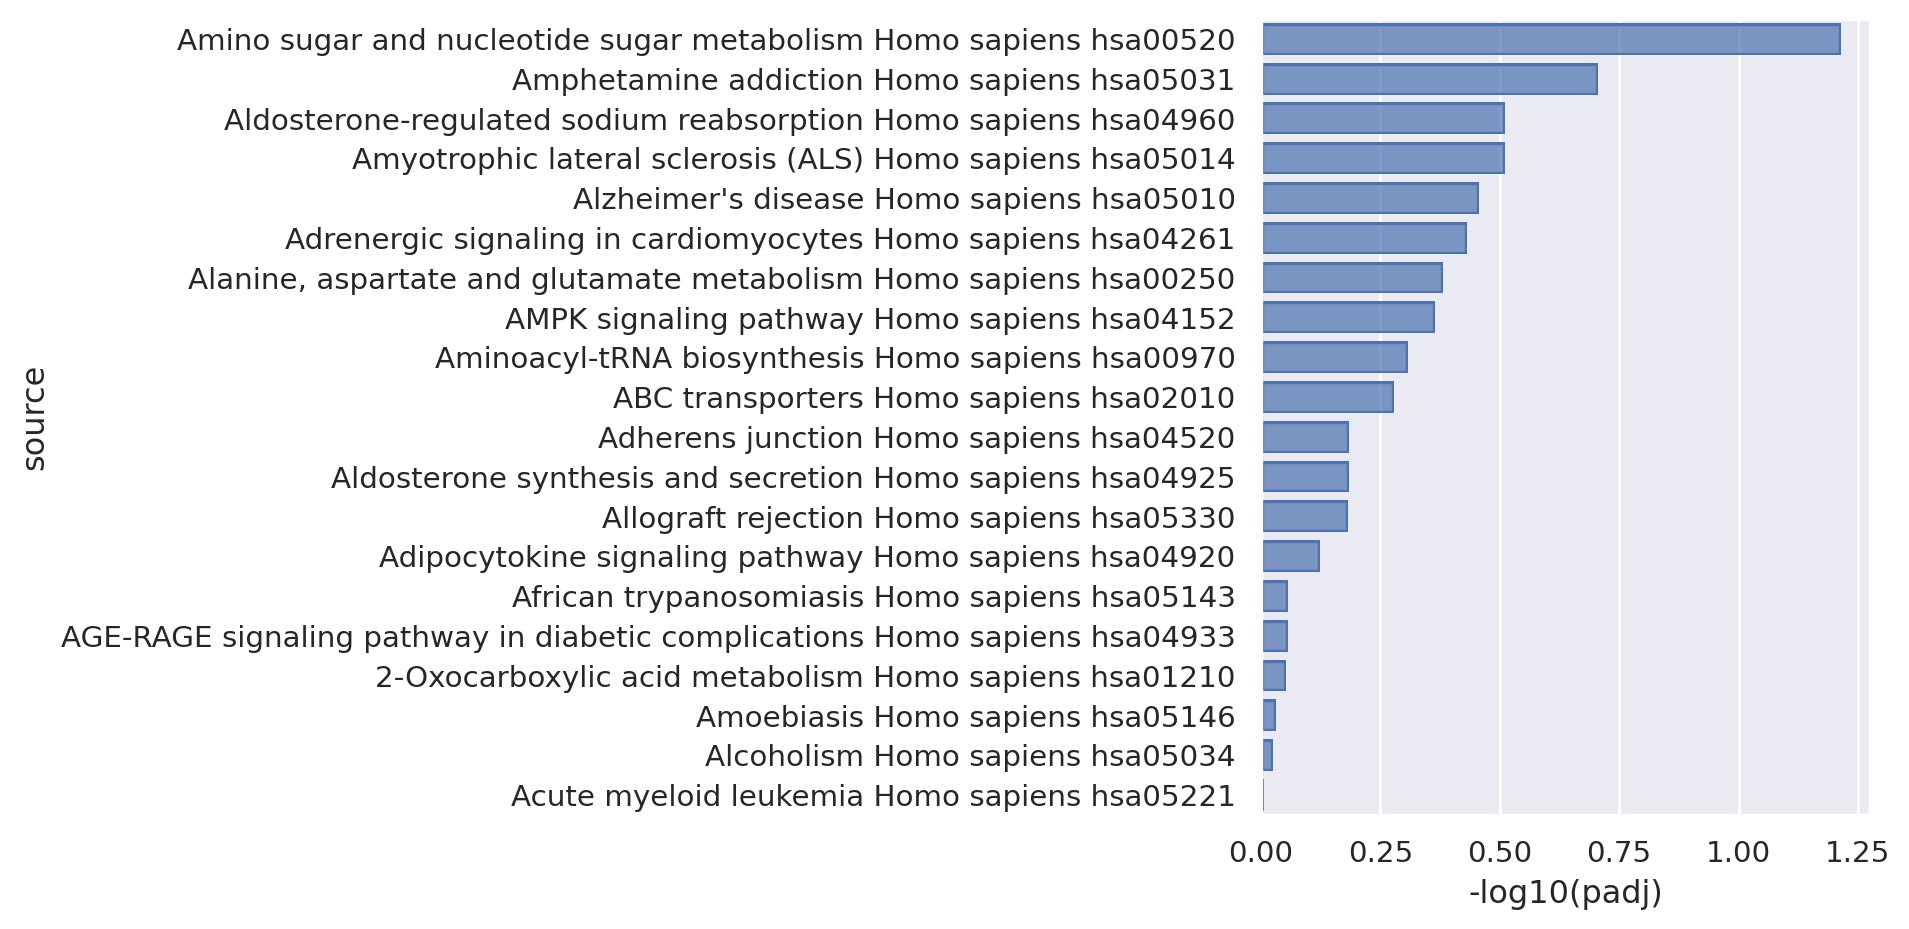

In [162]:
#plot enrichment of every pathway in the data as bar plot
(
    so.Plot(
        data=(
            pvals.T.head(20).sort_values('padj').assign(
                **{"-log10(padj)": lambda x: -np.log10(x["padj"])}
            )
        ),
        x="-log10(padj)",
        y="source",
    ).add(so.Bar()).layout(size=(10,5)).save('gsea_20-RA7d_meso/barplot20-ra', dpi=300)
)

In [163]:
pvals.T.head(20).sort_values('padj')


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
source,,,,,,
Amino sugar and nucleotide sugar metabolism Homo sapiens hsa00520,0.361000,0.871041,0.553554,0.415254,0.037000,0.061000
Amphetamine addiction Homo sapiens hsa05031,0.973000,0.645212,0.551000,0.557540,0.242000,0.197000
Aldosterone-regulated sodium reabsorption Homo sapiens hsa04960,0.579000,0.869707,0.818458,0.451546,0.189000,0.308000
Amyotrophic lateral sclerosis (ALS) Homo sapiens hsa05014,0.869000,0.933504,0.940941,0.945419,0.304000,0.309000
Alzheimer's disease Homo sapiens hsa05010,0.932000,0.481707,0.414000,0.931393,0.450000,0.350000
Adrenergic signaling in cardiomyocytes Homo sapiens hsa04261,0.901000,0.166667,0.176000,0.553320,0.122000,0.370000
"Alanine, aspartate and glutamate metabolism Homo sapiens hsa00250",0.212425,0.223183,0.387424,0.438563,0.454000,0.416000
AMPK signaling pathway Homo sapiens hsa04152,0.598000,0.503115,0.508000,0.158301,0.613000,0.433000
Aminoacyl-tRNA biosynthesis Homo sapiens hsa00970,0.753260,0.598540,0.543860,0.714286,0.367367,0.491491


In [120]:
# pvals

In [165]:
results_df=results_df.sort_values(by='FDR p-value')
# results_df.set_index('Term', inplace=True)

In [166]:
results_df

,Term,ES,NES,NOM p-value,FDR p-value,Set size,Tag %,Rank %,Leading edge
269,beta-Alanine metabolism Homo sapiens hsa00410,-0.522520,-1.483546,0.063910,0.996715,20,0.350000,0.148451,HIBCH;CNDP2;ABAT;SMOX;ALDH1A3;UPB1;MLYCD
271,cGMP-PKG signaling pathway Homo sapiens hsa04022,0.205129,0.818468,0.869231,0.996715,112,0.401786,0.309718,MYLK3;OPRD1;CACNA1D;PRKCE;SLC8A2;CREB1;ATP2A2;...
272,mRNA surveillance pathway Homo sapiens hsa03015,0.405315,1.487313,0.026263,0.996715,64,0.359375,0.214116,SMG7;DDX39B;PPP2R5A;NCBP1;PPP2R2B;CPSF7;PPP2CB...
273,mTOR signaling pathway Homo sapiens hsa04150,0.263174,0.871810,0.684825,0.996715,40,0.375000,0.204723,RRAGA;CAB39L;ULK3;IKBKB;DDIT4;PRKCB;HIF1A;BRAF...
274,p53 signaling pathway Homo sapiens hsa04115,-0.262656,-0.917617,0.595960,0.996715,50,0.280000,0.193135,PERP;CHEK2;CDK2;SESN2;CCNE1;CDK6;GTSE1;CASP8;C...
...,...,...,...,...,...,...,...,...,...
127,Jak-STAT signaling pathway Homo sapiens hsa04630,-0.172341,-0.655741,0.983505,1.000000,90,0.255556,0.222807,AKT1;PTPN6;PIAS4;PIK3R2;IFNGR2;IL24;CISH;IL4;C...
84,Focal adhesion Homo sapiens hsa04510,-0.162048,-0.669670,0.995565,1.000000,149,0.181208,0.167413,SHC3;MYL7;ITGA6;COL4A1;PPP1R12C;ARHGAP5;FLNB;M...
118,Hypertrophic cardiomyopathy (HCM) Homo sapiens...,0.178775,0.642132,0.972441,1.000000,58,0.137931,0.137301,ITGA10;ITGB8;ITGB3;TPM1;RYR2;SGCG;CACNA2D2;CACNB2
217,Renin secretion Homo sapiens hsa04924,-0.161791,-0.505330,0.991770,1.000000,32,0.218750,0.191818,PPP3R1;GNAI3;PTGER4;CLCA4;CALM2;ADRB2;CTSB


In [167]:
results_df.to_csv('gsea_20-RA7d_meso/results_df.csv')

Plot running score plots using the leading edges for every pathway. Also shows whether the pathway is upregulated or downregulated in the dataset.
running score shows the contribution of each gene in the query dataset by their enrichment score. The leading edge genes are near the peak of the trajectory.

In [ ]:
for i in range(20): # 20 an arbitrary number for top pathways we would like to visualise
    decoupler.plot_running_score(
        df=df_stats,
        stat='stat',
        net=kegg_pathways,
        source='source',
        target='target',
        set_name=results_df.Term[i],
        dpi=300,
        save=f'gsea_20-RA7d_meso/running_score_{i}'
    )

In [103]:
df_stats

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Human gene name,,,,,,
PTCRA,835.216946,2.204212,0.113340,19.447724,3.046592e-84,4.043133e-80
WDR59,452.352120,2.217068,0.130195,17.028762,5.025597e-65,1.111578e-61
MLKL,236.835510,2.422627,0.167089,14.499059,1.228228e-47,1.629981e-44
DSEL,234.328522,2.093514,0.161147,12.991297,1.370833e-38,1.399410e-35
RBM18,118.608021,3.291208,0.256648,12.823838,1.205806e-37,1.143018e-34
...,...,...,...,...,...,...
PSMB8,323.921673,-2.172326,0.142594,-15.234349,2.092016e-52,3.084794e-49
UGGT1,107.356219,-4.129833,0.264967,-15.586200,9.035128e-55,1.498815e-51
DIAPH2,193.209377,-3.098419,0.179150,-17.295160,5.116087e-67,1.357912e-63


References:
1. Pau Badia-i-Mompel, Jesús Vélez Santiago, Jana Braunger, Celina Geiss, Daniel Dimitrov, Sophia Müller-Dott, Petr Taus, Aurelien Dugourd, Christian H Holland, Ricardo O Ramirez Flores, Julio Saez-Rodriguez, decoupleR: ensemble of computational methods to infer biological activities from omics data, Bioinformatics Advances, Volume 2, Issue 1, 2022, vbac016, https://doi.org/10.1093/bioadv/vbac016
also see https://decoupler.readthedocs.io/en/latest/notebooks/example.html for a tutorial and explanations of how decoupler works
2. Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet 24, 550–572 (2023). https://doi.org/10.1038/s41576-023-00586-w
